# The tissues 3D reconstruction

This notebook demonstrates the process of tissues 3D reconstruction based on whole body 3D point cloud model. This is done in the following five steps.
1. Extract the 3D point cloud model of each tissue by the groups label；
2. (Optionally) Trim the original 3D point cloud model;
3. Construct the mesh model based on the 3D point cloud model;
4. Integrate multiple tissue models together to build a complete 3D model of the organism;
5. Construct the vocel model based on the mesh model;
6. Save the models as vtk file.

### Packages

In [9]:
import math
import os
import spateo as st
import numpy as np
import matplotlib.colors as mplc

### Data source

In [108]:
data_folder="/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction/E8-10_b_all_anno_scsq/1_reconstruct_whole_body/mesh"
wb_pc = st.tl.tdr.read_model(filename=os.path.join(data_folder, "pc_model.vtk"))
wb_mesh = st.tl.tdr.read_model(filename=os.path.join(data_folder, "surface_mesh_model.vtk"))
########################################################################################################################
save_folder = r"/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction"
save_cellbin_tdr_folder = os.path.join(save_folder, r"E8-10_b_all_anno_scsq")
save_cellbin_tdr_2_folder = os.path.join(save_cellbin_tdr_folder, r"2_reconstruct_tissues")
save_cellbin_tdr_mesh_folder = os.path.join(save_cellbin_tdr_2_folder, r"mesh")
save_cellbin_tdr_image_folder = os.path.join(save_cellbin_tdr_2_folder, r"image")

for folder in [save_folder, save_cellbin_tdr_folder, save_cellbin_tdr_2_folder, save_cellbin_tdr_mesh_folder, save_cellbin_tdr_image_folder]:
    if not os.path.exists(folder):
        os.mkdir(folder)

### Extract the 3D point cloud model of each tissue by the groups label

In [33]:
# tissues in groups
tissues = np.asarray(wb_pc.point_data["groups"])
unique_tissues = np.unique(tissues)
print(unique_tissues)

tissues_pc = []
for tissue in unique_tissues:
    # You can interactively select one or more tissues at the same time
    # tissue_pc_block = st.tl.interactive_pick(mesh=wb_pc, key="groups")
    # tissue_pc = [mesh for mesh in tissue_pc_block][0]
    # visualization(mesh=tissue_pc, jupyter=False, save_image=os.path.join(save_cellbin_tdr_image_folder, f"{tissue}_raw_pc_model.tif"))

    # You can also select the tissues by setting the parameters
    tissue_pc_block = st.tl.tdr.three_d_pick(model=wb_pc, key="groups", picked_groups=tissue)
    tissue_pc = [mesh for mesh in tissue_pc_block][0]
    tissues_pc.append(tissue_pc)

tissue_pc_models = st.tl.tdr.collect_model(models=tissues_pc, models_name=unique_tissues)

['CNS primordium' 'amnioserosa' 'clypeo-labral primordium'
 'epidermis primordium' 'midgut primordium' 'muscle primordium'
 'plasmatocyte primordium' 'procrystal cell' 'salivary gland primordium'
 'sensory nervous system' 'yolk nucleus']


#### Visualization

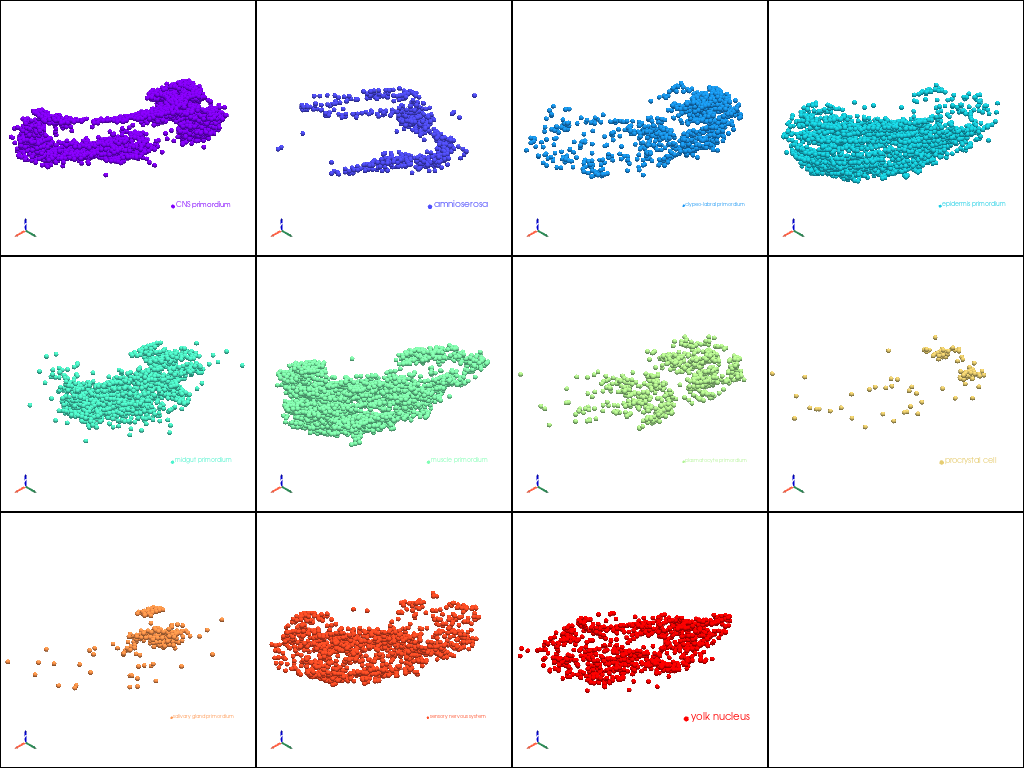

In [25]:
def visualize(models, key, shape, model_style="points", jupyter=False, filename=None):
    p = st.pl.create_plotter(jupyter=jupyter, background="white", shape=shape, window_size=(shape[1]*256, shape[0]*256), off_screen=True)
    for i, name in enumerate(models.keys()):
        index = math.floor(i / shape[1])
        col = i - shape[1] * index
        p.subplot(index, col)
        st.pl.add_model(plotter=p, model=models[name], key=key, point_size=5.0, model_style=model_style)
        st.pl.add_legend(plotter=p, model=models[name], key=key, legend_loc="lower right", legend_size=(0.3, 0.3))
        p.add_axes()
    st.pl.output_plotter(p=p, jupyter=jupyter, filename=filename)

## show in jupyter
visualize(models=tissue_pc_models, key="groups", shape=(3, 4), jupyter="static", filename=None)
## save the figure
visualize(models=tissue_pc_models, key="groups", shape=(3, 4), jupyter=False,
          filename=os.path.join(save_cellbin_tdr_image_folder, f"tissues_raw_pc_model.tiff"))

### (Optional)Trim the tissue 3D point cloud models

In [30]:
trim_tissues_pc = []
for name in tissue_pc_models.keys():
    trim_pc_block = st.tl.tdr.interactive_rectangle_clip(model=tissue_pc_models[name], invert=True)
    # If you want to have a reference when trimming the model, you can choose to add a background model
    # trim_pc_block = st.tl.tdr.interactive_rectangle_clip(model=tissue_pc_models[name], invert=True, bg_model=wb_pc)
    trim_pc = [i for i in trim_pc_block][0]
    trim_tissues_pc.append(trim_pc)

trim_tissue_pc_models = st.tl.tdr.collect_model(models=trim_tissues_pc, models_name=unique_tissues)

WARNING - 2022-05-04 19:50:27,346 - helpers - Encountered issue in callback (most recent call last):
  File "/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spateo/tools/TDR/weights/clip.py", line 26, in _split_model
    if not original_model.n_cells:
AttributeError: 'NoneType' object has no attribute 'n_cells'
WARNING - 2022-05-04 19:57:28,591 - helpers - Encountered issue in callback (most recent call last):
  File "/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spateo/tools/TDR/weights/clip.py", line 26, in _split_model
    if not original_model.n_cells:
AttributeError: 'NoneType' object has no attribute 'n_cells'
WARNING - 2022-05-04 19:59:11,853 - helpers - Encountered issue in callback (most recent call last):
  File "/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spateo/tools/TDR/weights/clip.py", line 26, in _split_model
    if not original_model.n_cells:
AttributeError: 'NoneType' object has no attribute 'n_cells'


#### Visualization

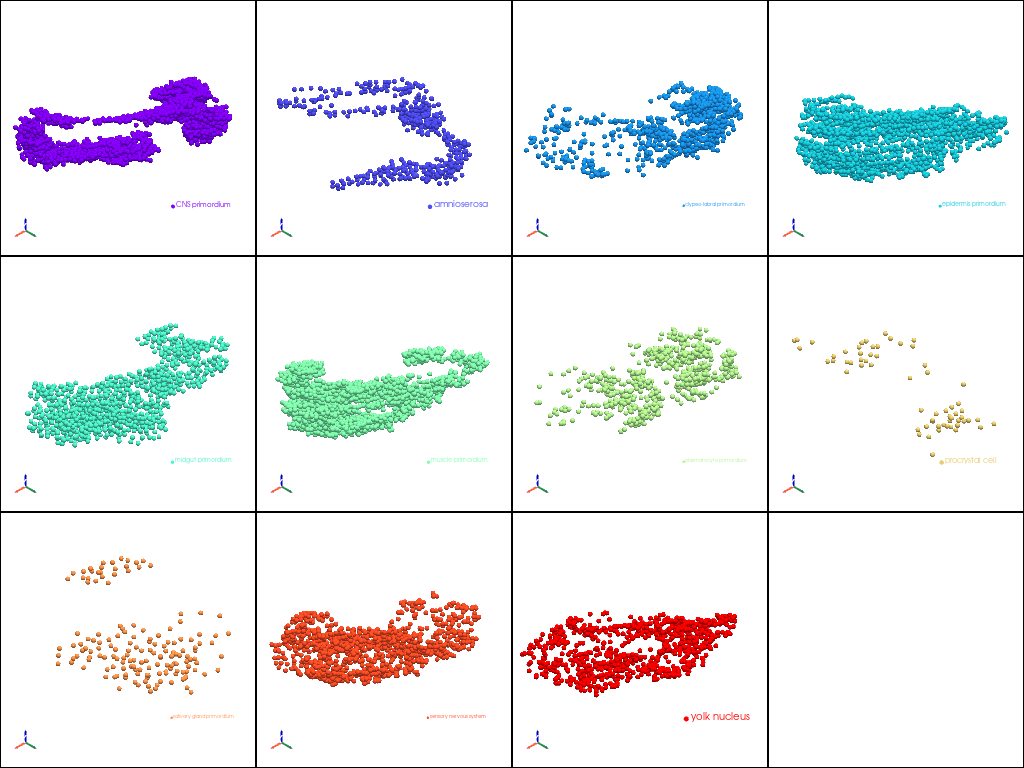

In [31]:
## show in jupyter
visualize(models=trim_tissue_pc_models, key="groups", shape=(3, 4), jupyter="static", filename=None)
## save the figure
visualize(models=trim_tissue_pc_models, key="groups", shape=(3, 4), jupyter=False,
          filename=os.path.join(save_cellbin_tdr_image_folder, f"tissues_trim_pc_model.tiff"))

#### Save the pc models

In [32]:
for name in trim_tissue_pc_models.keys():
    pc_model = trim_tissue_pc_models[name]
    st.tl.tdr.save_model(model=pc_model, filename=os.path.join(save_cellbin_tdr_mesh_folder, f"{name}_pc_model.vtk"))

### Construct the mesh model based on the 3D point cloud model

In [36]:
def tissue_visualize(model, key, model_style="points", jupyter=False, filename=None):
    p = st.pl.create_plotter(jupyter=jupyter, background="white", shape=(1, 4), window_size=(1024, 256), off_screen=True)
    for i, cpo in enumerate(["iso", "xy", "zx", "yz"]):
        p.subplot(0, i)
        st.pl.add_model(plotter=p, model=model, key=key, point_size=5.0, model_style=model_style)
        st.pl.add_legend(plotter=p, model=model, key=key, legend_loc="lower right")
        p.add_axes()
        p.camera_position = cpo
    st.pl.output_plotter(p=p, jupyter=jupyter, filename=filename)

#### CNS

In [87]:
tissue_name = "CNS primordium"
cns_pc = trim_tissue_pc_models[tissue_name]

# Reconstruct mesh model
color = mplc.to_hex(c= cns_pc["groups_rgba"][0], keep_alpha=True)
cns_mesh, cns_pc = st.tl.tdr.construct_surface(pc=cns_pc, key_added="groups", cs_method="marching_cube", smooth=1000, color=color, scale_factor=1.0)
st.tl.tdr.add_model_labels(model=cns_mesh, labels=np.asarray([tissue_name] * cns_mesh.n_cells),
                           key_added="tissue_name", colormap=color, inplace=True)

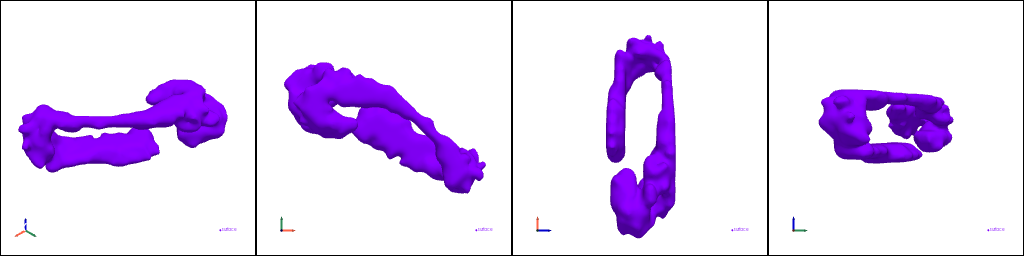

In [88]:
## show in jupyter
tissue_visualize(model=cns_mesh, key="groups", model_style="surface", jupyter="static", filename=None)
## save the figure
tissue_visualize(model=cns_mesh, key="groups", model_style="surface", jupyter=False,
                 filename=os.path.join(save_cellbin_tdr_image_folder, f"{tissue_name}_mesh_model.tiff"))

#### Midgut

In [89]:
tissue_name = "midgut primordium"
midgut_pc = trim_tissue_pc_models[tissue_name]

# Reconstruct mesh model
color = mplc.to_hex(c=midgut_pc["groups_rgba"][0], keep_alpha=True)
midgut_mesh, midgut_pc = st.tl.tdr.construct_surface(pc=midgut_pc, key_added="groups", cs_method="marching_cube", smooth=1000, color=color)
st.tl.tdr.add_model_labels(model=midgut_mesh, labels=np.asarray([tissue_name] * midgut_mesh.n_cells),
                           key_added="tissue_name", colormap=color, inplace=True)

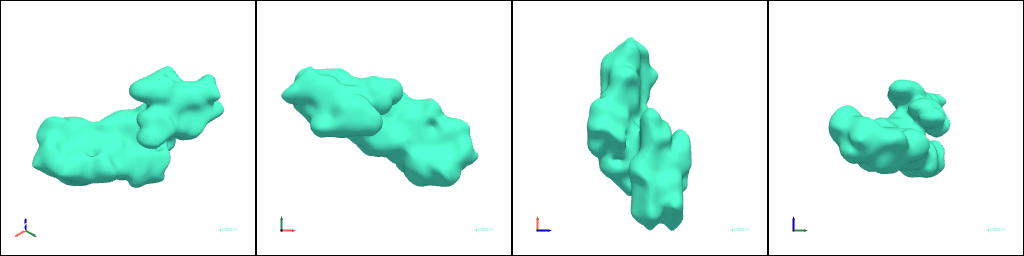

In [90]:
## show in jupyter
# tissue_visualize(model=midgut_pc, key="groups", model_style="points", jupyter="static", filename=None)
tissue_visualize(model=midgut_mesh, key="groups", model_style="surface", jupyter="static", filename=None)
## save the figure
tissue_visualize(model=midgut_mesh, key="groups", model_style="surface", jupyter=False,
                 filename=os.path.join(save_cellbin_tdr_image_folder, f"{tissue_name}_mesh_model.tiff"))

#### Muscle

In [91]:
tissue_name = "muscle primordium"
muscle_pc = trim_tissue_pc_models[tissue_name]

# Reconstruct mesh model
color = mplc.to_hex(c=muscle_pc["groups_rgba"][0], keep_alpha=True)
muscle_mesh, muscle_pc = st.tl.tdr.construct_surface(pc=muscle_pc, key_added="groups", cs_method="marching_cube", smooth=1000, color=color)
st.tl.tdr.add_model_labels(model=muscle_mesh, labels=np.asarray([tissue_name] * muscle_mesh.n_cells),
                           key_added="tissue_name", colormap=color, inplace=True)

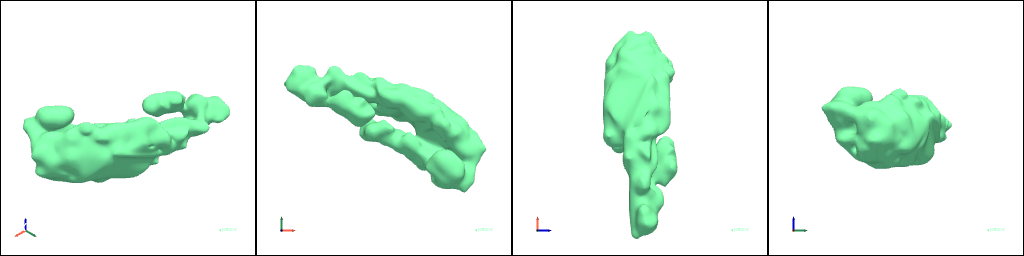

In [92]:
## show in jupyter
tissue_visualize(model=muscle_mesh, key="groups", model_style="surface", jupyter="static", filename=None)
## save the figure
tissue_visualize(model=muscle_mesh, key="groups", model_style="surface", jupyter=False,
                 filename=os.path.join(save_cellbin_tdr_image_folder, f"{tissue_name}_mesh_model.tiff"))

#### Salivary gland

In [93]:
tissue_name = "salivary gland primordium"
sg_pc = trim_tissue_pc_models[tissue_name]

# Reconstruct mesh model
color = mplc.to_hex(c=sg_pc["groups_rgba"][0], keep_alpha=True)
sg_mesh, sg_pc = st.tl.tdr.construct_surface(pc=sg_pc, key_added="groups", cs_method="marching_cube", smooth=1000, color=color)
st.tl.tdr.add_model_labels(model=sg_mesh, labels=np.asarray([tissue_name] * sg_mesh.n_cells),
                           key_added="tissue_name", colormap=color, inplace=True)

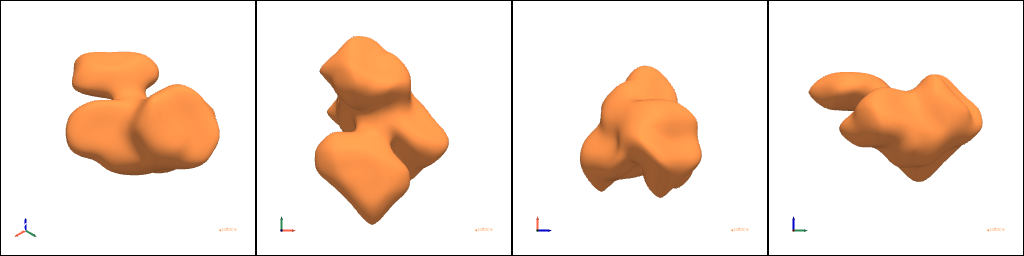

In [94]:
## show in jupyter
tissue_visualize(model=sg_mesh, key="groups", model_style="surface", jupyter="static", filename=None)
## save the figure
tissue_visualize(model=sg_pc, key="groups", model_style="surface", jupyter=False,
                 filename=os.path.join(save_cellbin_tdr_image_folder, f"{tissue_name}_mesh_model.tiff"))

#### Epidermis

In [95]:
tissue_name = "epidermis primordium"
epidermis_pc = trim_tissue_pc_models[tissue_name]

# Reconstruct mesh model
color = mplc.to_hex(c=epidermis_pc["groups_rgba"][0], keep_alpha=True)
epidermis_mesh, epidermis_pc = st.tl.tdr.construct_surface(pc=epidermis_pc, key_added="groups", cs_method="marching_cube", smooth=1000, color=color)
st.tl.tdr.add_model_labels(model=epidermis_mesh, labels=np.asarray([tissue_name] * epidermis_mesh.n_cells),
                           key_added="tissue_name", colormap=color, inplace=True)

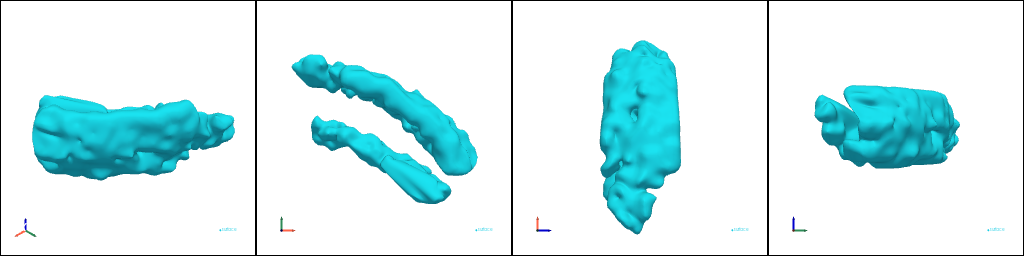

In [96]:
## show in jupyter
tissue_visualize(model=epidermis_mesh, key="groups", model_style="surface", jupyter="static", filename=None)
## save the figure
tissue_visualize(model=epidermis_mesh, key="groups", model_style="surface", jupyter=False,
                 filename=os.path.join(save_cellbin_tdr_image_folder, f"{tissue_name}_mesh_model.tiff"))

#### amnioserosa

In [143]:
tissue_name = "amnioserosa"
amnioserosa_pc = trim_tissue_pc_models[tissue_name]

# Reconstruct mesh model
color = mplc.to_hex(c=amnioserosa_pc["groups_rgba"][0], keep_alpha=True)
amnioserosa_mesh, amnioserosa_pc = st.tl.tdr.construct_surface(pc=amnioserosa_pc, key_added="groups", cs_method="marching_cube",
                                                               uniform_pc=True, uniform_pc_alpha=100, smooth=1000, color=color)
st.tl.tdr.add_model_labels(model=amnioserosa_mesh, labels=np.asarray([tissue_name] * amnioserosa_mesh.n_cells),
                           key_added="tissue_name", colormap=color, inplace=True)

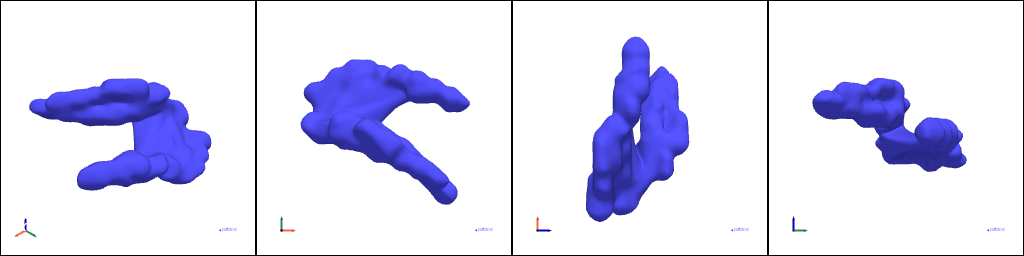

In [144]:
## show in jupyter
tissue_visualize(model=amnioserosa_mesh, key="groups", model_style="surface", jupyter="static", filename=None)
## save the figure
tissue_visualize(model=amnioserosa_mesh, key="groups", model_style="surface", jupyter=False,
                 filename=os.path.join(save_cellbin_tdr_image_folder, f"{tissue_name}_mesh_model.tiff"))

#### procrystal cell

In [101]:
tissue_name = "procrystal cell"
procrystal_pc = trim_tissue_pc_models[tissue_name]

# Reconstruct mesh model
color = mplc.to_hex(c=procrystal_pc["groups_rgba"][0], keep_alpha=True)
procrystal_mesh, procrystal_pc = st.tl.tdr.construct_surface(pc=procrystal_pc, key_added="groups", cs_method="marching_cube", smooth=1000, color=color)
st.tl.tdr.add_model_labels(model=procrystal_mesh, labels=np.asarray([tissue_name] * procrystal_mesh.n_cells),
                           key_added="tissue_name", colormap=color, inplace=True)

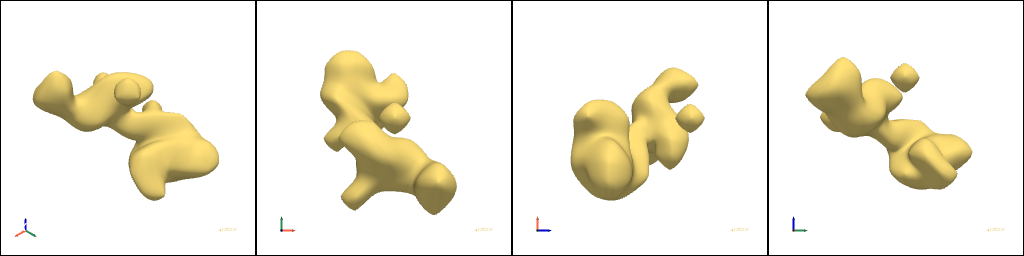

In [102]:
## show in jupyter
tissue_visualize(model=procrystal_mesh, key="groups", model_style="surface", jupyter="static", filename=None)
## save the figure
tissue_visualize(model=procrystal_mesh, key="groups", model_style="surface", jupyter=False,
                 filename=os.path.join(save_cellbin_tdr_image_folder, f"{tissue_name}_mesh_model.tiff"))

### Integrate multiple tissue models together to build a complete 3D model of the organism

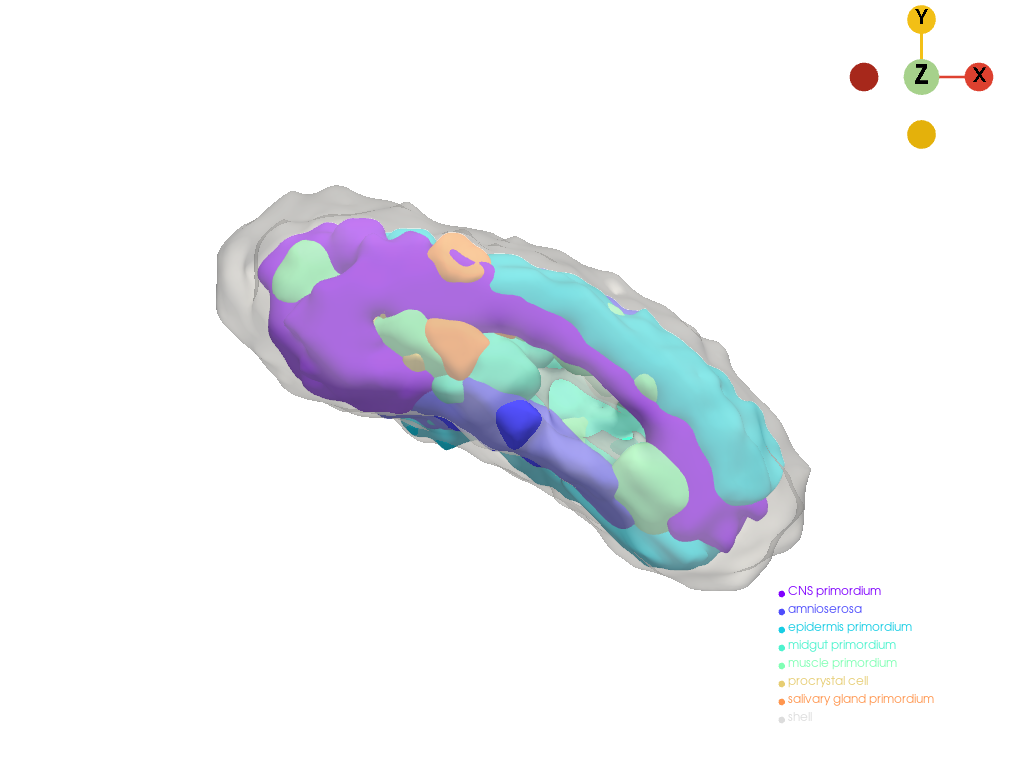

In [146]:
# Resize the shell
st.tl.tdr.add_model_labels(model=wb_mesh, labels=np.asarray(["shell"] * wb_mesh.n_cells),
                           key_added="tissue_name", colormap="gainsboro", alphamap=0.5, inplace=True)
shell = st.tl.tdr.scale_model(model=wb_mesh, scale_factor=1.05)

# Merge tissues meshes and shell mesh
meshes = [
    shell, cns_mesh, midgut_mesh, muscle_mesh, sg_mesh, epidermis_mesh, amnioserosa_mesh, procrystal_mesh
]
meshes_name = [
    "shell", "CNS primordium", "midgut primordium", "muscle primordium", "salivary gland primordium",
    "epidermis primordium", "amnioserosa", "procrystal cell"
]

mesh_models = st.tl.tdr.collect_model(meshes, meshes_name)
st.pl.three_d_plot(model=mesh_models, key="tissue_name", jupyter="static", initial_cpo="xy")

#### Save the mesh models

In [147]:
for name in mesh_models.keys():
    mesh_model = mesh_models[name]
    st.tl.tdr.save_model(model=mesh_model, filename=os.path.join(save_cellbin_tdr_mesh_folder, f"{name}_mesh_model.vtk"))

### Construct the volume based on the surface mesh

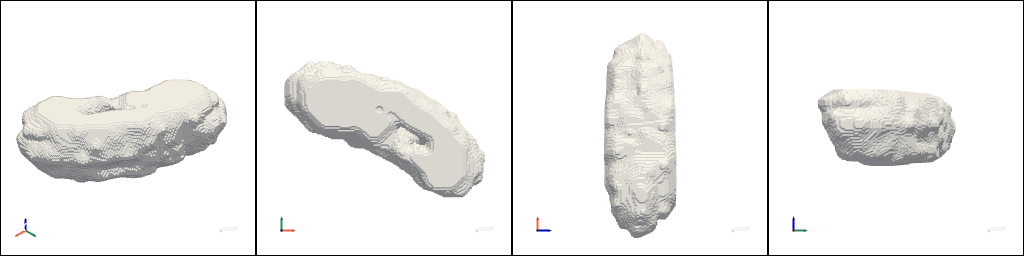

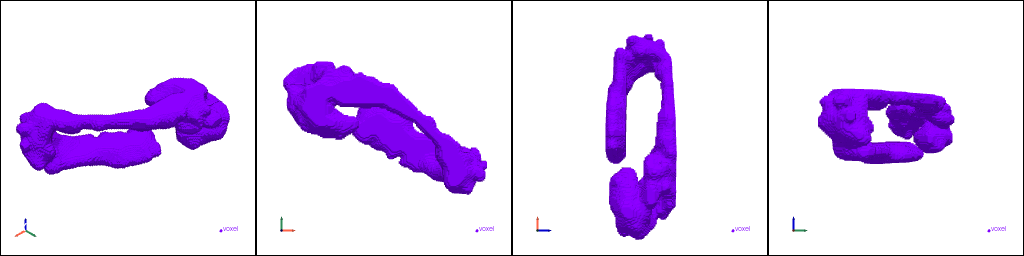

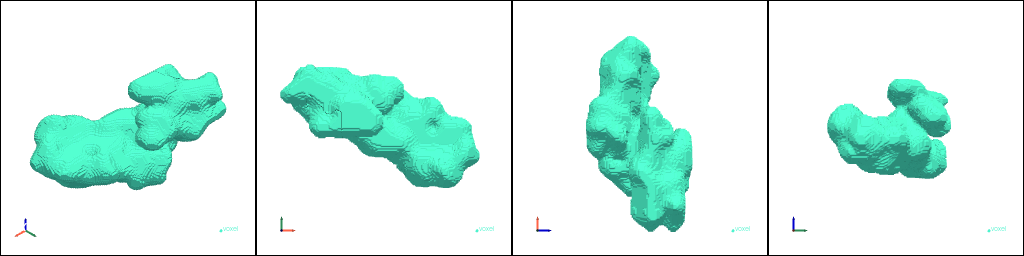

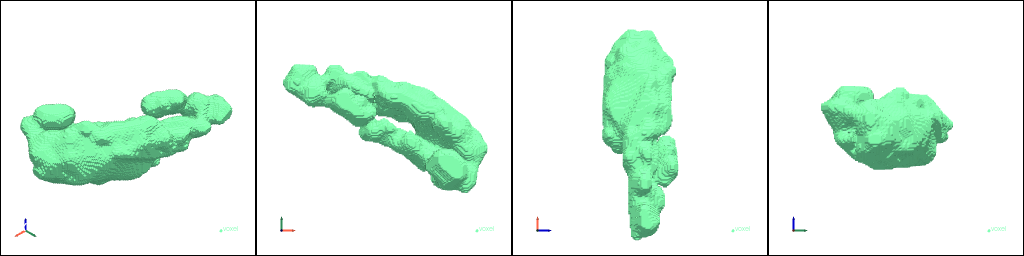

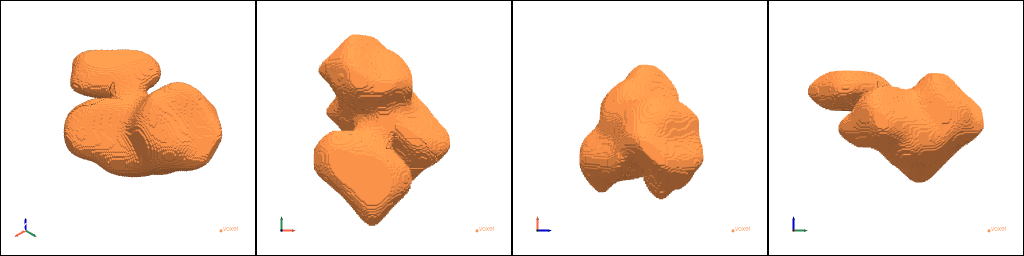

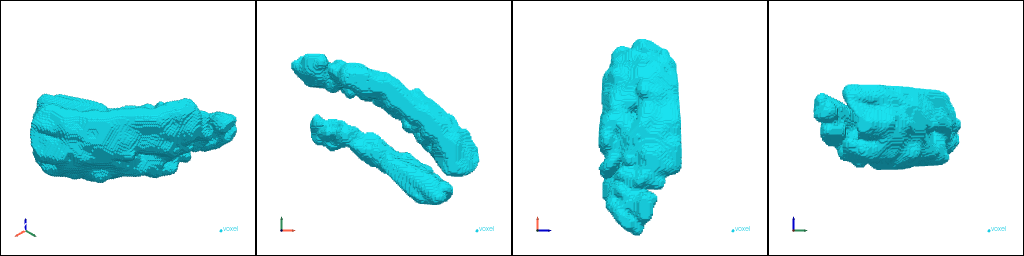

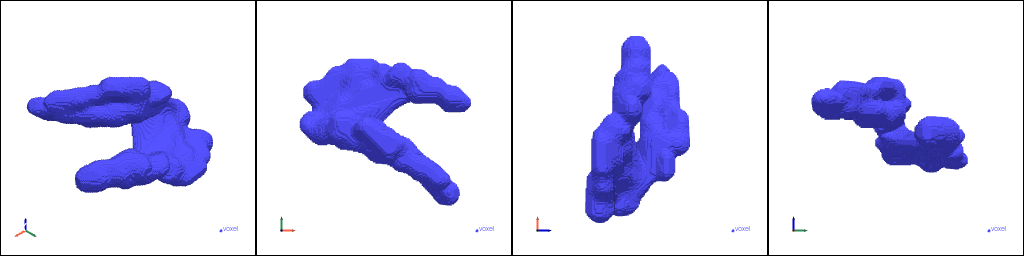

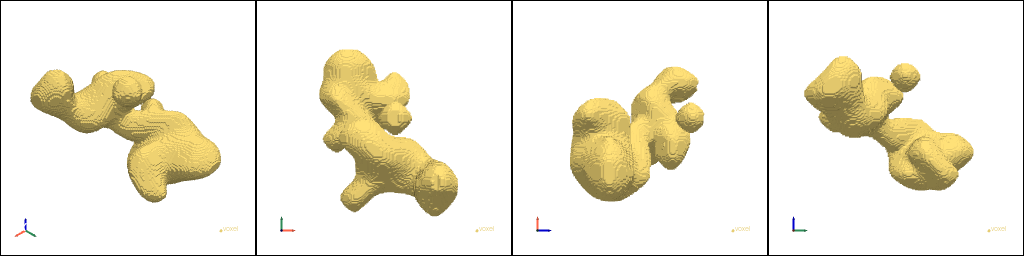

In [150]:
voxels = []
voxels_name = []
for name in mesh_models.keys():
    mesh_model = mesh_models[name]
    color = mplc.to_hex(c=mesh_model["groups_rgba"][0], keep_alpha=True)
    tissue_voxel = st.tl.tdr.voxelize_mesh(mesh=mesh_model, smooth=200, color=color)
    st.tl.tdr.add_model_labels(model=tissue_voxel, labels=np.asarray([name] * tissue_voxel.n_cells),
                               key_added="tissue_name", colormap=color, inplace=True)

    ## show in jupyter
    tissue_visualize(model=tissue_voxel, key="groups", model_style="surface", jupyter="static", filename=None)
    ## save the figure
    tissue_visualize(model=tissue_voxel, key="groups", model_style="surface", jupyter=False,
                     filename=os.path.join(save_cellbin_tdr_image_folder, f"{tissue_name}_voxel_model.tiff"))

    voxels.append(tissue_voxel)
    voxels_name.append(name)

#### Save the voxel models

In [153]:
voxel_models = st.tl.tdr.collect_model(models=voxels, models_name=voxels_name)
for name in voxel_models.keys():
    voxel_model = voxel_models[name]
    st.tl.tdr.save_model(model=voxel_model, filename=os.path.join(save_cellbin_tdr_mesh_folder, f"{name}_voxel_model.vtk"))